# K-Means clustering using Matrix Product States

In [1]:
import numpy as np
import tensornetwork as tn
import gzip
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import pandas as pd
from time import time

# sklearn utils
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# our KMeansMPS implementation
from KMeansMPS import KMeansMPS

np.random.seed(1493)

## Random clusters of normally distributed points

In [42]:
# generating random points clusters
Ncs  = 4    # number of cluster to generate
Dims = 2    # dimensions of the space

centers = np.random.randint(0, 20, (Ncs,Dims))
cluster_std = np.abs(np.random.randn(Ncs))
Npts = np.random.randint(20,80,Ncs)

dataset, true_labels = make_blobs(n_samples=Npts, 
                                  cluster_std=cluster_std, 
                                  centers=centers, 
                                  n_features=Dims, 
                                  random_state=1)
dataset.shape

(227, 2)

In [43]:
# KMeansMPS model
rand_points = KMeansMPS(n_classes = Ncs,
                        mps_size  = dataset.shape[1],
                        phys_dim  = 2,
                        bond_dim  = 1,
                        canonicalize = True)

# parameters
rand_points.max_iter = 20
rand_points.num_pts  = 50
rand_points.kmeans_pp= True
rand_points.verbose_ = False

#importing data
rand_points.import_data(dataset, feature_map="trig")

#training
rand_points.train()

In [44]:
# Sklearn KMeans model
sk_kmeans = KMeans(n_clusters=Ncs, random_state=65).fit(dataset)

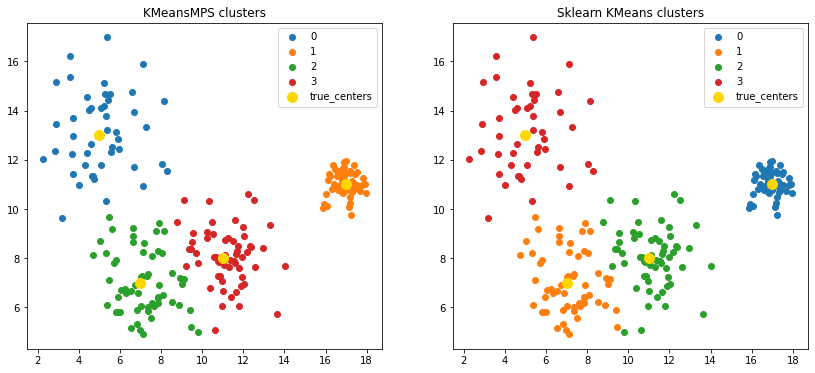

In [46]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

# visualise KMeansMPS clusters of the 2 dimensions
for ii in range(Ncs):
    to_plot = dataset[rand_points.labels==ii,:]
    ax[0].scatter(to_plot[:,0], 
                  to_plot[:,1], 
                  label=ii)
ax[0].scatter(centers[:,0], centers[:,1], c="gold", label="true_centers", s=100)
ax[0].set_title("KMeansMPS clusters")
ax[0].legend()

# visualise Sklearn KMeans clusters of the 2 dimensions
for ii in range(Ncs):
    to_plot = dataset[sk_kmeans.labels_==ii,:]
    ax[1].scatter(to_plot[:,0], 
                  to_plot[:,1], 
                  label=ii)
ax[1].scatter(centers[:,0], centers[:,1], c="gold", label="true_centers", s=100)
ax[1].set_title("Sklearn KMeans clusters")
ax[1].legend()

plt.savefig("RandPoints.pdf")
plt.show()

## Application to Breast-Cancer dataset

In [6]:
# loading data
breast_cancer = pd.read_csv("Data/breast-cancer-wisconsin.data", header=None)

breast_cancer = breast_cancer.apply(pd.to_numeric, errors='coerce') # replacing '?' with NaN
breast_cancer = breast_cancer.dropna()                              # removing rows containing NaN

breast_cancer.head(8) 

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4
6,1018099,1,1,1,1,2,10.0,3,1,1,2
7,1018561,2,1,2,1,2,1.0,3,1,1,2


In [7]:
dataset = breast_cancer.to_numpy().astype(np.float64)

#shuffling dataset
np.random.shuffle(dataset)

# splitting data and labels
fulldata    = dataset[:,1:10]
true_labels = dataset[:,10]

# split into training and test sets
test_data = fulldata[550:]
data      = fulldata[0:550]

In [8]:
# testing the kmeans MPS model
bond_dimensions = [1,2,8,32]
Ntrials = 10

train_accuracies = []
test_accuracies  = []
train_losses     = []

for bd in bond_dimensions: 
    print("\nBond dim: ", bd, "  |  trial #: ", end='')
    for nt in range(Ntrials):
        print(nt, ", ", end='')
        
        #initialize model
        breast_cl = KMeansMPS(n_classes = 2, 
                              mps_size  = data.shape[1],
                              phys_dim  = 2,
                              bond_dim  = bd,
                              canonicalize= True)
        breast_cl.max_iter = 20
        breast_cl.num_pts  = 50
        breast_cl.verbose_ = False

        # importing data
        breast_cl.import_data(data, feature_map="lin")

        # start train
        breast_cl.train()
        
        # save final losses
        train_losses.append(breast_cl.training_loss)

        # saving training accuracy
        train_acc = np.sum(((true_labels[:550]-2)//2).astype(np.int8)==breast_cl.labels)
        train_accuracies.append(max(train_acc, data.shape[0]-train_acc)/data.shape[0])
        
        # saving test accuracy
        test_labels = breast_cl.assign_labels(test_data)
        
        test_acc = np.sum(((true_labels[550:]-2)//2).astype(np.int8)==test_labels)
        test_accuracies.append(max(test_acc, test_data.shape[0]-test_acc)/test_data.shape[0])


Bond dim:  1   |  trial #: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 
Bond dim:  2   |  trial #: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 
Bond dim:  8   |  trial #: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 
Bond dim:  32   |  trial #: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

In [9]:
# printing best accuracies
for ii in range(len(bond_dimensions)):
    print("# Best obtained accuracies for bond dim.: ", bond_dimensions[ii])
    print("  train:", max(train_accuracies[ii*Ntrials:(ii+1)*Ntrials]) )
    print("  test :",  max(test_accuracies[ii*Ntrials:(ii+1)*Ntrials]) )

# Best obtained accuracies for bond dim.:  1
  train: 0.9727272727272728
  test : 0.9473684210526315
# Best obtained accuracies for bond dim.:  2
  train: 0.9727272727272728
  test : 0.9473684210526315
# Best obtained accuracies for bond dim.:  8
  train: 0.9727272727272728
  test : 0.9473684210526315
# Best obtained accuracies for bond dim.:  32
  train: 0.9727272727272728
  test : 0.9473684210526315


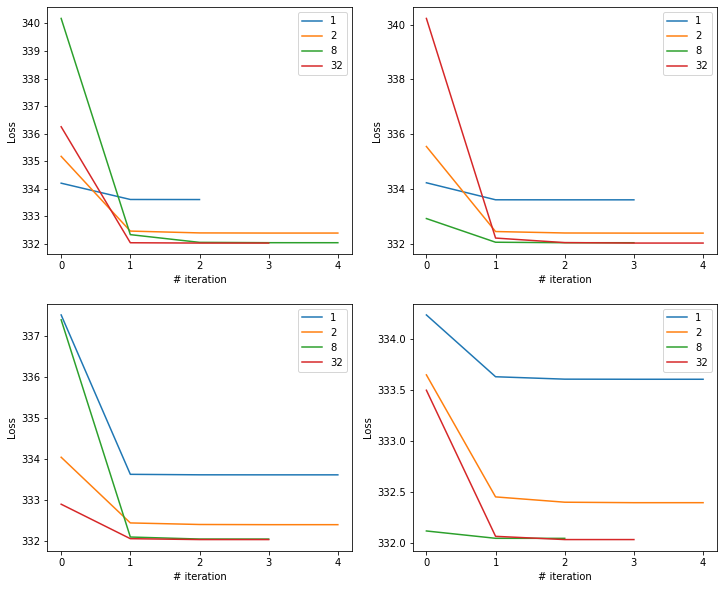

In [10]:
# plot of training loss for some trials
fig, ax = plt.subplots(2,2,figsize=(12,10))

offset = 0 # 0, 1
for j in range(4):
    for i in range(len(bond_dimensions)):
        ax[j//2,j%2].plot(range(len(train_losses[i*Ntrials+offset+j])), 
                          train_losses[i*Ntrials+offset+j], 
                          label=bond_dimensions[i])
        ax[j//2,j%2].legend()
        ax[j//2,j%2].set_xlabel("# iteration")
        ax[j//2,j%2].set_ylabel("Loss")
        ax[j//2,j%2].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

In [11]:
# comparing with the classic KMeans algorithm from Sklearn
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

sk_kmeans = KMeans(n_clusters=2, n_init=10).fit(scaled_features)
## Note: sklearn kmeans performs 10 trials and returns only the best result

# print training accuracy
temp = np.sum(((true_labels[:550]-2)//2).astype(np.int8)==sk_kmeans.labels_)
sk_train_accuracy = max(temp, data.shape[0]-temp) / data.shape[0]

# print test accuracy
scaled_test = scaler.transform(test_data)
sk_test_labels = sk_kmeans.predict(scaled_test)

temp = np.sum(((true_labels[550:]-2)//2).astype(np.int8)==sk_test_labels)
sk_test_accuracy = max(temp, test_data.shape[0]-temp) / test_data.shape[0]

print("Train accuracy: ", sk_train_accuracy)
print("Test accuracy : ", sk_test_accuracy )

Train accuracy:  0.9581818181818181
Test accuracy :  0.9548872180451128


# Application to High Energy Physics data

In [2]:
# we use a subset of a dataset of MonteCarlo simulations of Higgs bosons productions available at:
## https://archive.ics.uci.edu/ml/datasets/HIGGS
## the goal is to discriminate between signal (1) and background (0)

df_higgs = pd.read_csv("Data/Higgs_ridotto.csv", nrows=5000)
df_higgs.columns = range(29)  #renaming columns
df_higgs.head(8)

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,...,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
5,1.0,0.409391,-1.884684,-1.027292,1.672452,-1.604598,1.338015,0.055427,0.013466,2.173076,...,0.069496,1.377130,3.101961,0.869418,1.222083,1.000627,0.545045,0.698653,0.977314,0.828786
6,1.0,0.933895,0.629130,0.527535,0.238033,-0.966569,0.547811,-0.059439,-1.706866,2.173076,...,1.291248,-1.467454,0.000000,0.901837,1.083671,0.979696,0.783300,0.849195,0.894356,0.774879
7,1.0,1.405144,0.536603,0.689554,1.179567,-0.110061,3.202405,-1.526960,-1.576033,0.000000,...,-0.151202,1.163489,0.000000,1.667071,4.039273,1.175828,1.045352,1.542972,3.534827,2.740754


## Clustering based on the 7 high level features

In [4]:
# selecting only the 7 high level features
fulldata = df_higgs.to_numpy()[:,22:]
true_labels = df_higgs.to_numpy()[:,0]

# splitting train and test data (we assume that dataset is already shuffled)
N = fulldata.shape[0]
split_th = int(N * 0.80) # threshold for train/test splitting

data      = fulldata[:split_th,:]
test_data = fulldata[split_th:,:]

In [5]:
# testing the kmeans MPS model on HEP data
bond_dimensions = [1,8,32]
Ntrials = 10

train_accuracies = []
test_accuracies  = []
train_losses     = []

for bd in bond_dimensions: 
    print("\nBond dim: ", bd, "  |  trial #: ", end='')
    for nt in range(Ntrials):
        print(nt, ", ", end='')
        
        #initialize model
        higgs_cl = KMeansMPS(n_classes = 2, 
                              mps_size  = data.shape[1],
                              phys_dim  = 2,
                              bond_dim  = bd,
                              canonicalize= True)
        higgs_cl.max_iter = 20
        higgs_cl.num_pts  = 50
        higgs_cl.verbose_ = False

        # importing data
        higgs_cl.import_data(data, feature_map="trig")

        # start train
        higgs_cl.train()
        
        # save final losses
        train_losses.append(higgs_cl.training_loss)

        # saving training accuracy
        train_acc = np.sum((true_labels[:split_th]).astype(np.int8)==higgs_cl.labels)
        train_accuracies.append(max(train_acc, data.shape[0]-train_acc)/data.shape[0])
        
        # saving test accuracy
        test_labels = higgs_cl.assign_labels(test_data, apply_feature_map=True)
        
        test_acc = np.sum((true_labels[split_th:]).astype(np.int8)==test_labels)
        test_accuracies.append(max(test_acc, test_data.shape[0]-test_acc)/test_data.shape[0])


Bond dim:  1   |  trial #: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 
Bond dim:  8   |  trial #: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 
Bond dim:  32   |  trial #: 0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

In [6]:
for ii in range(len(bond_dimensions)):
    print("# Best obtained accuracies for bond dim.: ", bond_dimensions[ii])
    print("  train:", max(train_accuracies[ii*Ntrials:(ii+1)*Ntrials]) )
    print("  test :",  max(test_accuracies[ii*Ntrials:(ii+1)*Ntrials]) )

# Best obtained accuracies for bond dim.:  1
  train: 0.5915
  test : 0.58
# Best obtained accuracies for bond dim.:  8
  train: 0.59125
  test : 0.58
# Best obtained accuracies for bond dim.:  32
  train: 0.593
  test : 0.581


In [7]:
# Again, we compare our results with the classic KMeans algorithm from Sklearn
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

sk_kmeans = KMeans(n_clusters=2, n_init=10).fit(scaled_features)
## Note: sklearn kmeans performs 10 trials and returns only the best result

# print training accuracy
temp = np.sum((true_labels[:split_th]).astype(np.int8)==sk_kmeans.labels_)
sk_train_accuracy = max(temp, data.shape[0]-temp) / data.shape[0]

# print test accuracy
scaled_test = scaler.transform(test_data)
sk_test_labels = sk_kmeans.predict(scaled_test)

temp = np.sum((true_labels[split_th:]).astype(np.int8)==sk_test_labels)
sk_test_accuracy = max(temp, test_data.shape[0]-temp) / test_data.shape[0]

print("Train accuracy: ", sk_train_accuracy)
print("Test accuracy : ", sk_test_accuracy )

Train accuracy:  0.5555
Test accuracy :  0.549


## Clustering using the 21 low level features

In [8]:
# selecting features and labels
fulldata = df_higgs.to_numpy()[:,1:22]
true_labels = df_higgs.to_numpy()[:,0]

# splitting train and test data (we assume that dataset is already shuffled)
N = fulldata.shape[0]
split_th = int(N * 0.80) # threshold for train/test splitting

data      = fulldata[:split_th,:]
test_data = fulldata[split_th:,:]

In [9]:
# testing the kmeans MPS model on HEP data
bond_dimensions = [1,8,32]
Ntrials = 5

train_accuracies = []
test_accuracies  = []
train_losses     = []

for bd in bond_dimensions: 
    print("\nBond dim: ", bd, "  |  trial #: ", end='')
    for nt in range(Ntrials):
        print(nt, ", ", end='')
        
        #initialize model
        higgs_cl = KMeansMPS(n_classes = 2, 
                              mps_size  = data.shape[1],
                              phys_dim  = 2,
                              bond_dim  = bd,
                              canonicalize= True)
        higgs_cl.max_iter = 20
        higgs_cl.num_pts  = 50
        higgs_cl.verbose_ = False

        # importing data
        higgs_cl.import_data(data, feature_map="trig")

        # start train
        higgs_cl.train()
        
        # save final losses
        train_losses.append(higgs_cl.training_loss)

        # saving training accuracy
        train_acc = np.sum((true_labels[:split_th]).astype(np.int8)==higgs_cl.labels)
        train_accuracies.append(max(train_acc, data.shape[0]-train_acc)/data.shape[0])
        
        # saving test accuracy
        test_labels = higgs_cl.assign_labels(test_data, apply_feature_map=True)
        
        test_acc = np.sum((true_labels[split_th:]).astype(np.int8)==test_labels)
        test_accuracies.append(max(test_acc, test_data.shape[0]-test_acc)/test_data.shape[0])


Bond dim:  1   |  trial #: 0 , 1 , 2 , 3 , 4 , 
Bond dim:  8   |  trial #: 0 , 1 , 2 , 3 , 4 , 
Bond dim:  32   |  trial #: 0 , 1 , 2 , 3 , 4 , 

In [10]:
for ii in range(len(bond_dimensions)):
    print("# Best obtained accuracies for bond dim.: ", bond_dimensions[ii])
    print("  train:", max(train_accuracies[ii*Ntrials:(ii+1)*Ntrials]) )
    print("  test :",  max(test_accuracies[ii*Ntrials:(ii+1)*Ntrials]) )

# Best obtained accuracies for bond dim.:  1
  train: 0.54225
  test : 0.509
# Best obtained accuracies for bond dim.:  8
  train: 0.55375
  test : 0.536
# Best obtained accuracies for bond dim.:  32
  train: 0.52925
  test : 0.528


In [12]:
# Again, we compare our results with the classic KMeans algorithm from Sklearn
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

sk_kmeans = KMeans(n_clusters=2, n_init=10).fit(scaled_features)
## Note: sklearn kmeans performs 10 trials and returns only the best result

# print training accuracy
temp = np.sum((true_labels[:split_th]).astype(np.int8)==sk_kmeans.labels_)
sk_train_accuracy = max(temp, data.shape[0]-temp) / data.shape[0]

# print test accuracy
scaled_test = scaler.transform(test_data)
sk_test_labels = sk_kmeans.predict(scaled_test)

temp = np.sum((true_labels[split_th:]).astype(np.int8)==sk_test_labels)
sk_test_accuracy = max(temp, test_data.shape[0]-temp) / test_data.shape[0]

print("Train accuracy: ", sk_train_accuracy)
print("Test accuracy : ", sk_test_accuracy )

Train accuracy:  0.51475
Test accuracy :  0.503


## Clustering using all the 28 features

In [13]:
# selecting features and labels
fulldata = df_higgs.to_numpy()[:,1:]
true_labels = df_higgs.to_numpy()[:,0]

# splitting train and test data (we assume that dataset is already shuffled)
N = fulldata.shape[0]
split_th = int(N * 0.80) # threshold for train/test splitting

data      = fulldata[:split_th,:]
test_data = fulldata[split_th:,:]

In [14]:
# testing the kmeans MPS model on HEP data
bond_dimensions = [1,8,32]
Ntrials = 5

train_accuracies = []
test_accuracies  = []
train_losses     = []

for bd in bond_dimensions: 
    print("\nBond dim: ", bd, "  |  trial #: ", end='')
    for nt in range(Ntrials):
        print(nt, ", ", end='')
        
        #initialize model
        higgs_cl = KMeansMPS(n_classes = 2, 
                              mps_size  = data.shape[1],
                              phys_dim  = 2,
                              bond_dim  = bd,
                              canonicalize= True)
        higgs_cl.max_iter = 20
        higgs_cl.num_pts  = 50
        higgs_cl.verbose_ = False

        # importing data
        higgs_cl.import_data(data, feature_map="trig")

        # start train
        higgs_cl.train()
        
        # save final losses
        train_losses.append(higgs_cl.training_loss)

        # saving training accuracy
        train_acc = np.sum((true_labels[:split_th]).astype(np.int8)==higgs_cl.labels)
        train_accuracies.append(max(train_acc, data.shape[0]-train_acc)/data.shape[0])
        
        # saving test accuracy
        test_labels = higgs_cl.assign_labels(test_data, apply_feature_map=True)
        
        test_acc = np.sum((true_labels[split_th:]).astype(np.int8)==test_labels)
        test_accuracies.append(max(test_acc, test_data.shape[0]-test_acc)/test_data.shape[0])


Bond dim:  1   |  trial #: 0 , 1 , 2 , 3 , 4 , 
Bond dim:  8   |  trial #: 0 , 1 , 2 , 3 , 4 , 
Bond dim:  32   |  trial #: 0 , 1 , 2 , 3 , 4 , 

In [15]:
for ii in range(len(bond_dimensions)):
    print("# Best obtained accuracies for bond dim.: ", bond_dimensions[ii])
    print("  train:", max(train_accuracies[ii*Ntrials:(ii+1)*Ntrials]) )
    print("  test :",  max(test_accuracies[ii*Ntrials:(ii+1)*Ntrials]) )

# Best obtained accuracies for bond dim.:  1
  train: 0.529
  test : 0.532
# Best obtained accuracies for bond dim.:  8
  train: 0.55375
  test : 0.534
# Best obtained accuracies for bond dim.:  32
  train: 0.54225
  test : 0.529


In [16]:
# Again, we compare our results with the classic KMeans algorithm from Sklearn
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)

sk_kmeans = KMeans(n_clusters=2, n_init=10).fit(scaled_features)
## Note: sklearn kmeans performs 10 trials and returns only the best result

# print training accuracy
temp = np.sum((true_labels[:split_th]).astype(np.int8)==sk_kmeans.labels_)
sk_train_accuracy = max(temp, data.shape[0]-temp) / data.shape[0]

# print test accuracy
scaled_test = scaler.transform(test_data)
sk_test_labels = sk_kmeans.predict(scaled_test)

temp = np.sum((true_labels[split_th:]).astype(np.int8)==sk_test_labels)
sk_test_accuracy = max(temp, test_data.shape[0]-temp) / test_data.shape[0]

print("Train accuracy: ", sk_train_accuracy)
print("Test accuracy : ", sk_test_accuracy )

Train accuracy:  0.55825
Test accuracy :  0.549
